In [16]:
import numpy as np
import pandas as pd

import matplotlib as plt

%matplotlib inline

In [17]:
#The dataset provided consists of three csv files, each with slightly different schema
DATASET_1 = "dataset/7282_1.csv"
DATASET_2 = "dataset/Datafiniti_Hotel_Reviews.csv"
DATASET_3 = "dataset/Datafiniti_Hotel_Reviews_Jun19.csv"

DATASETS_IN_USE = [DATASET_1, DATASET_2, DATASET_3]

MIN_REVIEW_LENGTH = 0

TRAIN_PROPORTION = 0.1

USE_TRANSLATOR = True
TRANSLATOR_FUNCTIONALITY = "translate" #options are "translate", which translates non-english text to english, and 
                                        # "remove", which drops records with non-english text from the training set

## 1. Pre-Preparation and Exploratory Analysis

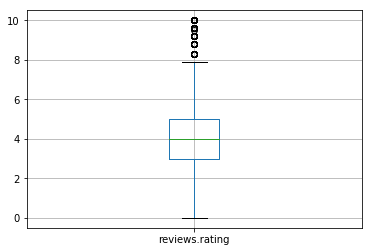

In [48]:
df_1 = pd.read_csv(DATASET_1)

#print(df)
#df_1.head()

df_1.boxplot(column="reviews.rating")

In [53]:
df_1[df_1["reviews.rating"] > 5]

,address,categories,city,country,latitude,longitude,name,postalCode,province,reviews.date,reviews.dateAdded,reviews.doRecommend,reviews.id,reviews.rating,reviews.text,reviews.title,reviews.userCity,reviews.username,reviews.userProvince
4448,Taragaon Boudha,Hotels,Alliance,US,27.72160,85.355959,Hyatt Regency Kathmandu,44601,OH,2015-08-11T00:00:00Z,2016-11-11T23:48:28Z,NaN,NaN,9.6,The wifi signal was too low Loved The location,Location,NaN,Mohsin,NaN
4449,Taragaon Boudha,Hotels,Alliance,US,27.72160,85.355959,Hyatt Regency Kathmandu,44601,OH,2016-01-12T00:00:00Z,2016-11-11T23:48:28Z,NaN,NaN,10.0,None what so ever. The staff were all friendly...,The staff were all friendly whether at the 6th...,NaN,Hassan,NaN
4450,Taragaon Boudha,Hotels,Alliance,US,27.72160,85.355959,Hyatt Regency Kathmandu,44601,OH,2015-06-22T00:00:00Z,2016-11-11T23:48:28Z,NaN,NaN,10.0,Friendly staff in a beautiful setting combined...,Lovely place and business as usual.,NaN,Anonymous,NaN
4451,Taragaon Boudha,Hotels,Alliance,US,27.72160,85.355959,Hyatt Regency Kathmandu,44601,OH,2016-05-17T00:00:00Z,2016-11-11T23:48:28Z,NaN,NaN,8.3,nil location,location,NaN,Davide,NaN
4452,Taragaon Boudha,Hotels,Alliance,US,27.72160,85.355959,Hyatt Regency Kathmandu,44601,OH,2016-07-09T00:00:00Z,2016-11-11T23:48:28Z,NaN,NaN,8.8,"room cooling, wifi connection slow, certain el...",it was really enjoyable.,NaN,Khurram,NaN
4453,Taragaon Boudha,Hotels,Alliance,US,27.72160,85.355959,Hyatt Regency Kathmandu,44601,OH,2016-04-05T00:00:00Z,2016-11-11T23:48:28Z,NaN,NaN,9.2,The trips arranging lady gave us wrong informa...,Great hotel,NaN,Hadla,NaN
4454,Taragaon Boudha,Hotels,Alliance,US,27.72160,85.355959,Hyatt Regency Kathmandu,44601,OH,2016-08-06T00:00:00Z,2016-11-11T23:48:28Z,NaN,NaN,10.0,Staff was amazing. So cheerful and helpful. I ...,Amazing hotel!!!,NaN,Artur,NaN
4455,Taragaon Boudha,Hotels,Alliance,US,27.72160,85.355959,Hyatt Regency Kathmandu,44601,OH,2016-05-20T00:00:00Z,2016-11-11T23:48:28Z,NaN,NaN,9.2,bathroom fittings poorly maintained (not polis...,Friendly efficient staff,NaN,Robert,NaN
4456,Taragaon Boudha,Hotels,Alliance,US,27.72160,85.355959,Hyatt Regency Kathmandu,44601,OH,2015-09-06T00:00:00Z,2016-11-11T23:48:28Z,NaN,NaN,7.5,Very slow WiFi Bedroom view,Bedroom view,NaN,Anonymous,NaN
4457,Taragaon Boudha,Hotels,Alliance,US,27.72160,85.355959,Hyatt Regency Kathmandu,44601,OH,2015-12-12T00:00:00Z,2016-11-11T23:48:28Z,NaN,NaN,8.8,We were led to believe there would be transpor...,Enjoyed the history of Nepal.,NaN,Anonymous,NaN


In [61]:
print(df_1["reviews.rating"].value_counts())

df_1[df_1["reviews.rating"] == 0].head()

5.0     12671
4.0      9755
3.0      5708
1.0      3068
2.0      2979
0.0       337
10.0      101
9.6        53
9.2        49
4.3        26
4.8        25
8.3        25
7.9        24
7.5        24
8.8        24
4.2        22
3.4        17
4.1        14
6.3        14
7.1        13
4.5        13
6.7        12
5.4         9
4.6         7
3.1         7
5.8         6
4.4         6
3.3         6
4.7         6
4.9         6
2.4         4
2.5         3
3.8         3
3.7         2
3.2         2
3.9         2
2.8         1
1.3         1
9.5         1
1.5         1
6.0         1
2.9         1
7.0         1
Name: reviews.rating, dtype: int64


,address,categories,city,country,latitude,longitude,name,postalCode,province,reviews.date,reviews.dateAdded,reviews.doRecommend,reviews.id,reviews.rating,reviews.text,reviews.title,reviews.userCity,reviews.username,reviews.userProvince
57,2113 Sapp Brothers Dr,"Lodging,Hotels,Motels",Percival,US,40.689730,-95.788826,Americas Best Value Inn,51648,IA,NaN,2016-04-06T13:03:08Z,NaN,NaN,0.0,to share your opinion of this businesswith YP ...,NaN,NaN,write a review,NaN
58,2860 Grand Ave,"Hotels,Restaurants",Los Olivos,US,34.664684,-120.115036,Intermezzo,93441,CA,NaN,2016-05-06T14:12:01Z,NaN,NaN,0.0,to share your opinion of this businesswith YP ...,NaN,NaN,write a review,NaN
59,142 Park Place Us 181 Business At Park Pl,Hotels,Kenedy,US,28.793795,-97.849655,Studio 6,78119,TX,NaN,2016-05-07T01:34:14Z,NaN,NaN,0.0,to share your opinion of this businesswith YP ...,NaN,NaN,write a review,NaN
79,435 E Avenida Olancha,"Hotels,Hotel",Palm Springs,US,33.802822,-116.542690,Little Paradise Hotel,92264,CA,2016-07-12T00:00:00Z,2015-10-21T17:46:10Z,NaN,NaN,0.0,to share your opinion of this businesswith YP ...,Lovely oasis of rest,Brussels,write a review,CA
97,316 N Main St,"Motels,Hotels,Restaurants,Bed & Breakfast & Inns",Neihart,US,46.933598,-110.735886,Little Belt Inn Neihart,59465,MT,NaN,2016-06-16T21:25:59Z,NaN,NaN,0.0,to share your opinion of this businesswith YP ...,NaN,NaN,write a review,NaN


From the unique values in DATASET_1, it seems that, while most of the reviews are rated on an integer scale between 1 and 5, at least some of the reviews are rated from 1.0-10.0. These reviews

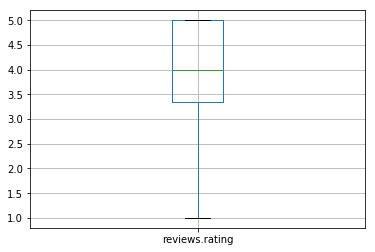

In [63]:
df_2 = pd.read_csv(DATASET_2)
df_2.head()

df_2.boxplot(column="reviews.rating")



In [62]:
print(df_2["reviews.rating"].value_counts())

5.00    4384
4.00    2397
3.00    1187
1.00     572
2.00     561
4.80     162
4.60     155
4.40     102
3.75      91
4.15      78
3.95      52
3.55      50
3.35      40
3.15      37
2.90      34
2.70      23
2.50      19
2.30      12
2.10      11
1.65       8
1.45       6
4.50       4
1.90       4
3.25       2
3.50       2
1.25       2
4.25       2
2.75       1
4.75       1
3.45       1
Name: reviews.rating, dtype: int64


5    4840
4    2849
3    1190
1     567
2     554
Name: reviews.rating, dtype: int64


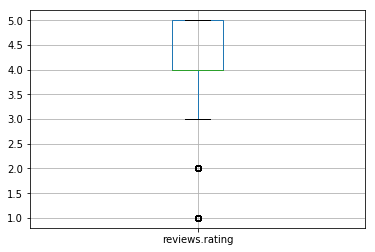

In [57]:
df_3 = pd.read_csv(DATASET_3)
df_3.head()

df_3.boxplot(column="reviews.rating")
print(df_3["reviews.rating"].value_counts())

In [29]:
#Find the columns that are present in each of the three datasets, and make sure that there aren't any important columns
# (review text, title, rating, etc.) that are functionally identical, but named differently
columns_intersection = set.intersection(set(df_1.columns.values),set(df_2.columns.values), set(df_3.columns.values))
print(columns_intersection)

{'latitude', 'country', 'longitude', 'reviews.title', 'province', 'reviews.userProvince', 'reviews.rating', 'city', 'reviews.date', 'categories', 'reviews.username', 'reviews.userCity', 'postalCode', 'address', 'reviews.text', 'name'}


In [32]:
#now concatenate the three data sources on the schema intersection

df = pd.concat([df_1, df_2, df_3], join="inner")

print(df.head())

                  address categories      city country   latitude  longitude  \
0  Riviera San Nicol 11/a     Hotels  Mableton      US  45.421611  12.376187   
1  Riviera San Nicol 11/a     Hotels  Mableton      US  45.421611  12.376187   
2  Riviera San Nicol 11/a     Hotels  Mableton      US  45.421611  12.376187   
3  Riviera San Nicol 11/a     Hotels  Mableton      US  45.421611  12.376187   
4  Riviera San Nicol 11/a     Hotels  Mableton      US  45.421611  12.376187   

                 name postalCode province          reviews.date  \
0  Hotel Russo Palace      30126       GA  2013-09-22T00:00:00Z   
1  Hotel Russo Palace      30126       GA  2015-04-03T00:00:00Z   
2  Hotel Russo Palace      30126       GA  2014-05-13T00:00:00Z   
3  Hotel Russo Palace      30126       GA  2013-10-27T00:00:00Z   
4  Hotel Russo Palace      30126       GA  2015-03-05T00:00:00Z   

   reviews.rating                                       reviews.text  \
0             4.0  Pleasant 10 min walk alon

In [33]:
df.count()

address                 55912
categories              55912
city                    55912
country                 55912
latitude                55826
longitude               55826
name                    55912
postalCode              55857
province                55912
reviews.date            55653
reviews.rating          55050
reviews.text            55889
reviews.title           54288
reviews.userCity        30427
reviews.username        55869
reviews.userProvince    30221
dtype: int64

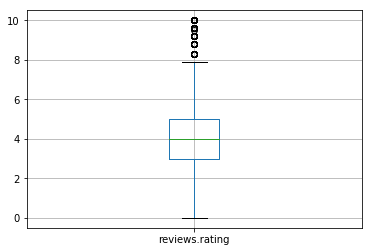

In [44]:
df.boxplot(column="reviews.rating")

In [46]:
df[df["reviews.rating"] > 5]

,address,categories,city,country,latitude,longitude,name,postalCode,province,reviews.date,reviews.rating,reviews.text,reviews.title,reviews.userCity,reviews.username,reviews.userProvince
4448,Taragaon Boudha,Hotels,Alliance,US,27.72160,85.355959,Hyatt Regency Kathmandu,44601,OH,2015-08-11T00:00:00Z,9.6,The wifi signal was too low Loved The location,Location,NaN,Mohsin,NaN
4449,Taragaon Boudha,Hotels,Alliance,US,27.72160,85.355959,Hyatt Regency Kathmandu,44601,OH,2016-01-12T00:00:00Z,10.0,None what so ever. The staff were all friendly...,The staff were all friendly whether at the 6th...,NaN,Hassan,NaN
4450,Taragaon Boudha,Hotels,Alliance,US,27.72160,85.355959,Hyatt Regency Kathmandu,44601,OH,2015-06-22T00:00:00Z,10.0,Friendly staff in a beautiful setting combined...,Lovely place and business as usual.,NaN,Anonymous,NaN
4451,Taragaon Boudha,Hotels,Alliance,US,27.72160,85.355959,Hyatt Regency Kathmandu,44601,OH,2016-05-17T00:00:00Z,8.3,nil location,location,NaN,Davide,NaN
4452,Taragaon Boudha,Hotels,Alliance,US,27.72160,85.355959,Hyatt Regency Kathmandu,44601,OH,2016-07-09T00:00:00Z,8.8,"room cooling, wifi connection slow, certain el...",it was really enjoyable.,NaN,Khurram,NaN
4453,Taragaon Boudha,Hotels,Alliance,US,27.72160,85.355959,Hyatt Regency Kathmandu,44601,OH,2016-04-05T00:00:00Z,9.2,The trips arranging lady gave us wrong informa...,Great hotel,NaN,Hadla,NaN
4454,Taragaon Boudha,Hotels,Alliance,US,27.72160,85.355959,Hyatt Regency Kathmandu,44601,OH,2016-08-06T00:00:00Z,10.0,Staff was amazing. So cheerful and helpful. I ...,Amazing hotel!!!,NaN,Artur,NaN
4455,Taragaon Boudha,Hotels,Alliance,US,27.72160,85.355959,Hyatt Regency Kathmandu,44601,OH,2016-05-20T00:00:00Z,9.2,bathroom fittings poorly maintained (not polis...,Friendly efficient staff,NaN,Robert,NaN
4456,Taragaon Boudha,Hotels,Alliance,US,27.72160,85.355959,Hyatt Regency Kathmandu,44601,OH,2015-09-06T00:00:00Z,7.5,Very slow WiFi Bedroom view,Bedroom view,NaN,Anonymous,NaN
4457,Taragaon Boudha,Hotels,Alliance,US,27.72160,85.355959,Hyatt Regency Kathmandu,44601,OH,2015-12-12T00:00:00Z,8.8,We were led to believe there would be transpor...,Enjoyed the history of Nepal.,NaN,Anonymous,NaN
